In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
#from project_utils.feature_stats    import Feature_Statistics
#from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data
#from project_utils.surroagte_gp     import Surrogate_GP




(1000,)


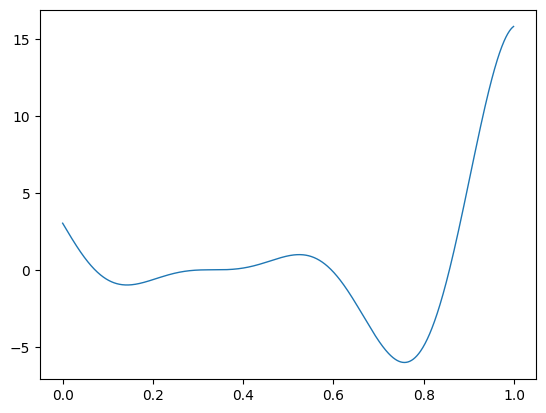

(1000, 1)


In [2]:
# Load Forrester model

Forrester_Data = BB_Model('Forrester')

#Forrester_Data.df().head()

In [3]:
Forrester_Data.Random_Forest()

0.9999403681428756


RandomForestRegressor(random_state=RandomState(MT19937) at 0x1DF7B5E9840)

In [4]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Forrester_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Forrester_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Forrester_Data.get_features(),
                   categorical_features = Forrester_Data.get_catagorical(),
                   mode                 = Forrester_Data.get_mode(),
                   sampling_method      = "Gaussian")

#sur_GP = Surrogate_GP()


In [5]:
mean_x = np.mean(X_train, axis=0)
std_x = np.std(X_train, axis=0)
print('Mean 0:', mean_x)
print('Std 0: ', std_x)


Mean 0: [0.501845]
Std 0:  [0.29099998]


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import Matern
#from sklearn.gaussian_process.kernels import RBF

#from sklearn.inspection import permutation_importance

from matplotlib import pyplot as plt

from unravel_2.acquisition_function import FUR_W

from copy import deepcopy

from project_utils.surroagte_gp     import Surrogate_GP


In [7]:
def train_gaussian_process(x_train, y_train):

    kernel = Matern()
    
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10, optimizer='fmin_l_bfgs_b', normalize_y = False, copy_X_train=True)
    gpr.fit(x_train, y_train)
        
    return gpr
    


In [8]:
X_train, X_test, y_train, y_test = Forrester_Data.get_TT_data()

X_sur_train = np.array([[0.4]])

X_init = np.array([0.4])
y_init = Forrester_Data.get_Random_Forest().predict(X_init.reshape(1, -1))

y_sur_train = np.array(y_init)


std_x  = np.std (X_train, axis=0)
mean_x = np.mean(X_train, axis=0)

acqdata = Acq_Data()

w0=0.5
w1=0.5

N_points = 1000

In [9]:
GP = train_gaussian_process(X_sur_train, y_sur_train)


In [10]:
f_acqu = np.ones(N_points)*6
t1     = np.ones(N_points)*3
t2     = np.ones(N_points)*3
iter   = 0
delta  = np.random.randn()


In [11]:
def _compute_acq(x, i):
        
    mean_p, std_p = GP.predict(X = x.reshape(1,-1), return_std = True)
        
        
    t1[i] = w0 * -np.linalg.norm(x - X_init - std_x * delta / np.log(iter))
#    t1[i] = w0 * -np.linalg.norm(x - X_init)

    t2[i] = w1 * std_p
        
    f_acqu[i] = t1[i] + t2[i]
                                         



In [12]:
def plot_point():
        
    xrange = np.arange(0.0, 1.0, 1.0/N_points)
    yvals  = Acq_Data.Forrester(xrange)
        
    fig, ax1 = plt.subplots()
        
    color = 'darkblue'
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.tick_params(axis='y', labelcolor=color)
        
    ax1.plot(xrange, yvals, linewidth=1.0, color = color)
        
    color = 'green'
    ax1.scatter(X_init, [y_init], linewidth=1.0, color = color, marker = 'o')
        
    color = 'red'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
    ax2.set_ylabel('Acquisition Function')
    ax2.plot(xrange, f_acqu, color=color,       label='FUR W')
    ax2.plot(xrange, t1,     color='lime',      label='T1')
    ax2.plot(xrange, t2,     color='darkgreen', label='T2')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend()


    fig.tight_layout()
        
    plt.show()

In [13]:
for i in range(N_points):
    x = float(i)/float(N_points)
    x = np.array([x])
    _compute_acq(x, i)

plot_point()

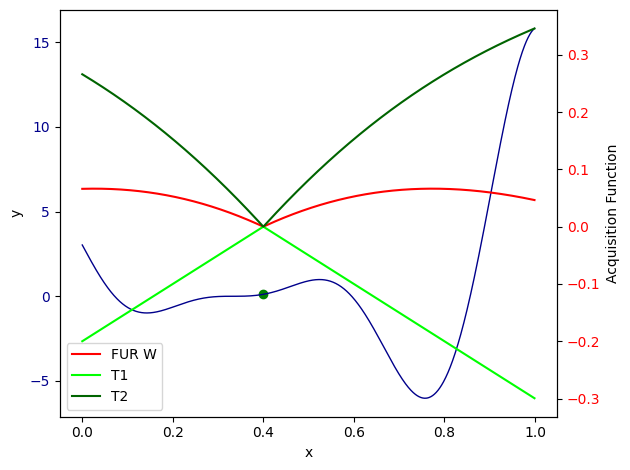